## Initialization

### Imports

In [1]:
import os
import pathlib
import sys
from typing import List, Dict, Set, Tuple, Generator

import torch
import numpy as np
from pyspark.sql import SparkSession, functions as F
from sklearn.cluster import KMeans

sys.path.append(str(pathlib.Path().absolute().parent))
from config import GRAPH_MINING_PATH, BASE_PATH
from utils import display_df
from question4.application import (
    Graph,
    Graph2VecDataPreparer,
    NegativeSampleGenerator,
    Graph2VecModel,
    Graph2VecLoss,
    OptimizerGenerator,
    BatchGenerator,
    train,
    plot_wss,
)

### Configs

In [2]:
WL_SUBGRAPH_ITERATIONS = 2

NUMBER_OF_NEGATIVE_SAMPLES = 20
EMBEDDING_DIM = 2
BATCH_SIZE=2048
INITIAL_LEARNING_RATE = 1e-2
EPOCHS = 10

DISPLAY = True

SPARK_THREADS = 6
SPARK_DRIVER_MEMORY = 6
SPARK_MAX_RESULT_SIZE = 4

### Spark

In [3]:
spark = (
    SparkSession.builder.master(f"local[{SPARK_THREADS}]")
    .config("spark.driver.memory", f"{SPARK_DRIVER_MEMORY}g")
    .config("spark.driver.maxResultSize", f"{SPARK_MAX_RESULT_SIZE}g")
    .config("spark.sql.session.timeZone", "Asia/Tehran")
    .getOrCreate()
)

23/10/22 23:09:01 WARN Utils: Your hostname, tapsi-UX430UNR resolves to a loopback address: 127.0.1.1; using 192.168.1.13 instead (on interface wlp2s0)
23/10/22 23:09:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/22 23:09:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Preparation

### Read `graph-mining` Data

In [4]:
graph_mining_df = spark.read.option("header", True).csv(GRAPH_MINING_PATH)

display_df(graph_mining_df, display=DISPLAY)

root
 |-- source: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- count: string (nullable = true)
 |-- amount: string (nullable = true)

DataFrame size: 1630291
+----------------------------------------+----------------------------------------+-----+------------------+
|source                                  |destination                             |count|amount            |
+----------------------------------------+----------------------------------------+-----+------------------+
|7479f1f41c98df7af456abb89ec889f13d33a2b3|8cc381a1b8bce880529f94947a5c014032004c44|1    |3.0               |
|7479f1f41c98df7af456abb89ec889f13d33a2b3|6b2ff3cb3ed6fd3662de8836fd05e6bdbbe21c1e|2    |3.0000000000483045|
|7479f1f41c98df7af456abb89ec889f13d33a2b3|ca85466287029f8cfa975504a52b31dd95a2d64b|1    |3.000034779200078 |
|7479f1f41c98df7af456abb89ec889f13d33a2b3|717ea8213b20a36385ccacd003f74a1de4e8597c|1    |3.0               |
|7479f1f41c98df7af456abb89ec889f13d33a2b3|095880193

### Create `graph`

In [5]:
graph = Graph([
    (edge["source"], edge["destination"])
    for edge in graph_mining_df.collect()
])

## Solutions

### Part A

#### Connected Components

In [6]:
connected_components = graph.get_connected_components()

connected_components[:5]

[{'5ae7dec6439558a3d416b946475f14eef8b8a829',
  '9d2e75d43a875e9ed5c75bf053422abb3f6ff9d1',
  'f9b969f95f41d178aa4577314da0bd72bef9dc34',
  '0a275b9d39b943eac0747dec9114a9f7c5df1307',
  'da962bb61953683a5e7dcbab3ffe5249c6a69f40',
  '502e90a9c2f7e6e4c21035a916042eaf7d0b7050',
  '7254f3f85ecd233d5e2da7b38ca8970b122df530',
  'cbe7634f7577c8e157be94377f787a8fc875e824',
  '13468d9c2c3424025266e7202710ecb5a7d46f66',
  '31660e5f11446f311e547797302369b998dde481',
  '02cf08789233c77e9632b0664e2d3e4123bd947f',
  'd8934dfb4529ecf8b18ca7bfdf457159df074238',
  '53254c7926054a77772abffa6f2d3a0a97126f97',
  '60181dda29a42c94fbeb0d12648226dc0bf6456a',
  'de059246544f7824ed2037521eed8fc592f62fda',
  'cbc8d5fe29654c45f88d4e34932ac025c86d5e93',
  '6e1399191b024a00867cddc0d5601464e909b4f2',
  '3c2058cb27c12daa0d20a04551f2d86f5ac4245a',
  '851682a53d95f5ffbc0459b2e8f58b8988c09196',
  '0ec8e88a35b2ef242e5892e286b50d41433ce82c',
  'c2f5e709a2be8ad4dd5c1a604bb18a0653c44a17',
  'b080483e91bb420fc6a666229f099a3

#### Strongly Connected Components

In [7]:
strongly_connected_components = graph.get_strongly_connected_components()

strongly_connected_components[:5]

[{'423be14315081255f1dcac6664e67436e7a37430'},
 {'26d061db0b882196f933bac1267630f7935acf16'},
 {'46cd2ceb868f2c98a45429a8d084cc4a9bfb37b4'},
 {'22baff534413e1b8756ed4cd055df35504b83f84'},
 {'e6db5b98bc858179bf1af8aa29f2f60ce715acd9'}]

### Part B

In [8]:
sorted_connected_components = sorted(
    connected_components,
    key=lambda sub_graph_nodes: len(sub_graph_nodes),
)

largest_connected_components_nodes = sorted_connected_components[-1]

In [9]:
largest_connected_components_nodes_df = spark.createDataFrame(
    [
        (node,) for node
        in largest_connected_components_nodes
    ],
    schema=["node"]
)

largest_connected_components_edges_df = (
    graph_mining_df
    .join(
        largest_connected_components_nodes_df
        .select(F.col("node").alias("source")),
        on="source"
    )
)

In [10]:
largest_connected_components_graph = Graph(
    edges=[
        (edge["source"], edge["destination"])
        for edge in largest_connected_components_edges_df.collect()
    ],
    edges_weight={
        (edge["source"], edge["destination"]): edge["count"]
        for edge in largest_connected_components_edges_df.collect()
    }
)

largest_connected_components_communities = (
    largest_connected_components_graph.get_graph_communities()
)

largest_connected_components_communities[:5]

23/10/22 23:09:58 WARN TaskSetManager: Stage 7 contains a task of very large size (5365 KiB). The maximum recommended task size is 1000 KiB.


[{'00006b78202d11abbfa21ad7d099197cc1afcd9e',
  '7920a754d84f6d3d0eeabd4d95bdd4d9d7c622aa'},
 {'1262ae9e9ea154b35bf0f51c2b35dbb2ca502753',
  '14e6c886bbeb14faf3d422e811ed41c5b444cad3',
  '3365a1edea04d22e710cf9223b221054048e439a',
  '33fc4e95c174ff9720b1b17eea085bfd02996794',
  '3c43d7c7bd39a011688ed56cfb39500899bd43fd',
  '556663e3e7f72986f68cff0a1240590ef8c6b19d',
  '674f61d162cbf9e003828a556ddea9eb34c260b5',
  '67dab26b245bd929885eea3898d53d659cc548e2',
  'aeae86f1e37837053cd44d323bd93d81afb26b84',
  'be0bf10fa786584ded7e07d38eccfd090b0023d8',
  'cac065ebbaf62df13d5e69c79a55fe3b1c277428',
  'ce8d4303728ee15ee77854b6f69248d61e54b06d',
  'ddf1ed030997209033bc22b9a23b3a6fdf389bad',
  'e4b26de4a7f30fd9f8465e26dd57833c479228c3'},
 {'1c54c4c7a58defd7aacf8e60a46a65ae374e9e38',
  '35d112b89fb4093664b99c2357939381f12eddd6',
  '3895dd16e6b8e09edf659ddba2fd4f2c568dd3f7',
  '4eefe70eec5ed0372971950ea92c6a57e35a0d52',
  '625956f09f2346653ddcd477edf1e7bdef2155a9',
  '6369875dc979702784549401aa8cf

### Part C

In [11]:
print("Size of Largest Connected Components:", len(sorted_connected_components[-1]))
print("Size of Second Largest Connected Components:", len(sorted_connected_components[-2]))

Size of Largest Connected Components: 736029
Size of Second Largest Connected Components: 62


According to the result of the cell above, we can remove the largest group and cluster the rest.

#### Remove values

In [12]:
del (
    graph,
    connected_components,
    strongly_connected_components,
    sorted_connected_components,
)

#### Create Graph without Largest Connected Components

##### Create `largest-connected-components-nodes` Data

In [13]:
largest_connected_components_nodes_df = spark.createDataFrame(
    data=[(node,) for node in largest_connected_components_nodes],
    schema=["node"],
)

del largest_connected_components_nodes

display_df(largest_connected_components_nodes_df, display=DISPLAY)

root
 |-- node: string (nullable = true)



23/10/22 23:12:06 WARN TaskSetManager: Stage 14 contains a task of very large size (5365 KiB). The maximum recommended task size is 1000 KiB.


DataFrame size: 736029
+----------------------------------------+
|node                                    |
+----------------------------------------+
|5ae7dec6439558a3d416b946475f14eef8b8a829|
|9d2e75d43a875e9ed5c75bf053422abb3f6ff9d1|
|f9b969f95f41d178aa4577314da0bd72bef9dc34|
|0a275b9d39b943eac0747dec9114a9f7c5df1307|
|da962bb61953683a5e7dcbab3ffe5249c6a69f40|
+----------------------------------------+
only showing top 5 rows



23/10/22 23:12:06 WARN TaskSetManager: Stage 17 contains a task of very large size (5365 KiB). The maximum recommended task size is 1000 KiB.


##### Remove largest-connected-components-nodes from graph-mining Data

In [14]:
graph_mining_without_largest_connected_components_df = (
    graph_mining_df
    .join(
        largest_connected_components_nodes_df
        .select(
            F.col("node").alias("source"),
            F.lit("1").alias("isInLargestConnectedComponents"),
        ),
        on="source",
        how="left",
    )
    .filter(F.col("isInLargestConnectedComponents").isNull())
    .drop("isInLargestConnectedComponents")
)

del largest_connected_components_nodes_df

graph_mining_without_largest_connected_components_df.persist()

display_df(
    graph_mining_without_largest_connected_components_df, 
    display=DISPLAY,
)

root
 |-- source: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- count: string (nullable = true)
 |-- amount: string (nullable = true)



23/10/22 23:12:08 WARN TaskSetManager: Stage 19 contains a task of very large size (5365 KiB). The maximum recommended task size is 1000 KiB.


DataFrame size: 179894
+----------------------------------------+----------------------------------------+-----+------------------+
|source                                  |destination                             |count|amount            |
+----------------------------------------+----------------------------------------+-----+------------------+
|000266fc1b59e4e289ec552a6282483d41a05859|0109c710fdb9da2a9cc0341004be8a16ea43a85a|8    |3.004395710511168 |
|0003ffa3b4b4519e4bfc0908ba1d62a64f4e0030|485a43581790b74112cf01311de3a8b1e5b88930|1    |3.000048304463338 |
|0003ffa3b4b4519e4bfc0908ba1d62a64f4e0030|f72bb9c6c19b95b18ef8e852d44ed72711b614ab|1    |3.000241522509908 |
|0003ffa3b4b4519e4bfc0908ba1d62a64f4e0030|bc119da02146d4bd4d2dc49458c136ed2dc516a3|1    |3.000048304463338 |
|00045a1e149611ab9a03a1d4025c53bd1f84be04|800ccacaad68c1f829432af1efef55f1caf89e3a|3    |3.0028016616269637|
+----------------------------------------+----------------------------------------+-----+----------------

##### Create `graph-node` Data

In [15]:
graph_node_df = (
    graph_mining_without_largest_connected_components_df
    .groupBy(F.col("source").alias("node"))
    .agg(F.sum("count").alias("sourceCount"))
    .join(
        graph_mining_without_largest_connected_components_df
        .groupBy(F.col("destination").alias("node"))
        .agg(F.sum("count").alias("destinationCount")),
        on="node",
        how="full",
    )
    .fillna(0)
    .withColumn(
        "nodeHash",
        F.hash(
            F.col("sourceCount"),
            F.col("destinationCount"),
        ),
    )
    .select("node", "nodeHash")
)

display_df(graph_node_df, display=DISPLAY)

root
 |-- node: string (nullable = true)
 |-- nodeHash: integer (nullable = false)

DataFrame size: 210045


+----------------------------------------+-----------+
|node                                    |nodeHash   |
+----------------------------------------+-----------+
|000266fc1b59e4e289ec552a6282483d41a05859|-1172331840|
|0003ffa3b4b4519e4bfc0908ba1d62a64f4e0030|-1906450826|
|00045a1e149611ab9a03a1d4025c53bd1f84be04|-1514340034|
|0005a355730ae07d6d726bd721f1f92bb2e1b234|-2120512597|
|000c53e46632ea2c3d31863d14af7da1ddd59654|1610320073 |
+----------------------------------------+-----------+
only showing top 5 rows



#### Prepare Data for training

In [16]:
graph_2vec_data_preparer = Graph2VecDataPreparer(
    wl_sub_graph_iterations=WL_SUBGRAPH_ITERATIONS,
)

data = graph_2vec_data_preparer.transform(
    graph_df=graph_mining_without_largest_connected_components_df,
    hash_df=graph_node_df,
)

In [17]:
positive_training_input = data["positive_training_input"]
positive_training_target = data["positive_training_target"]

sub_graph_index_to_sub_graph_nodes = (
    data["sub_graph_index_to_sub_graph_nodes"]
)
sub_graph_index_to_wl_indices = (
    data["sub_graph_index_to_wl_indices"]
)

number_of_wl_sub_graphs = data["number_of_wl_sub_graphs"]

#### Train Graph2VecModel

In [18]:
model = Graph2VecModel(
    input_dim=len(sub_graph_index_to_sub_graph_nodes),
    target_dim=number_of_wl_sub_graphs,
    embedding_dim=EMBEDDING_DIM,
)

loss_calculator = Graph2VecLoss(embedding_dim=EMBEDDING_DIM)

batch_generator = BatchGenerator(batch_size=BATCH_SIZE)

optimazer_generator = OptimizerGenerator(
    initial_learning_rate=INITIAL_LEARNING_RATE,
    model=model,
)

negative_sample_generator = NegativeSampleGenerator(
    sub_graph_index_to_wl_indices=sub_graph_index_to_wl_indices,
    number_of_negative_samples=NUMBER_OF_NEGATIVE_SAMPLES,
    number_of_wl_sub_graphs=number_of_wl_sub_graphs,
)

In [19]:
model = train(
    model=model,
    positive_training_input=positive_training_input,
    positive_training_target=positive_training_target,
    loss_calculator=loss_calculator,
    batch_generator=batch_generator,
    optimizer_generator=optimazer_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    negative_sample_generator=negative_sample_generator,
)

Epoch: 10, Loss: 0.5088899220606599: 100%|██████████████| 964/964 [00:44<00:00, 21.66it/s]


#### Save Embedder Model

In [20]:
os.makedirs(
    os.path.join(
        BASE_PATH,
        "question4",
        "graph_embeder_model",
    ),
    exist_ok=True,
)

torch.save(
    model.get_graph_embedder(),
    os.path.join(
        BASE_PATH,
        "question4",
        "graph_embeder_model",
        "graph_embeder.pt"
    )
)

#### Load Embedder model

In [21]:
embedder_model = torch.load(
    os.path.join(
        BASE_PATH,
        "question4",
        "graph_embeder_model",
        "graph_embeder.pt"
    ),
)

embedder_model.eval()

GraphEmbedder(
  (graph_embedder): Embedding(78479, 2)
)

#### Cluster Connected Sub-Graphes 

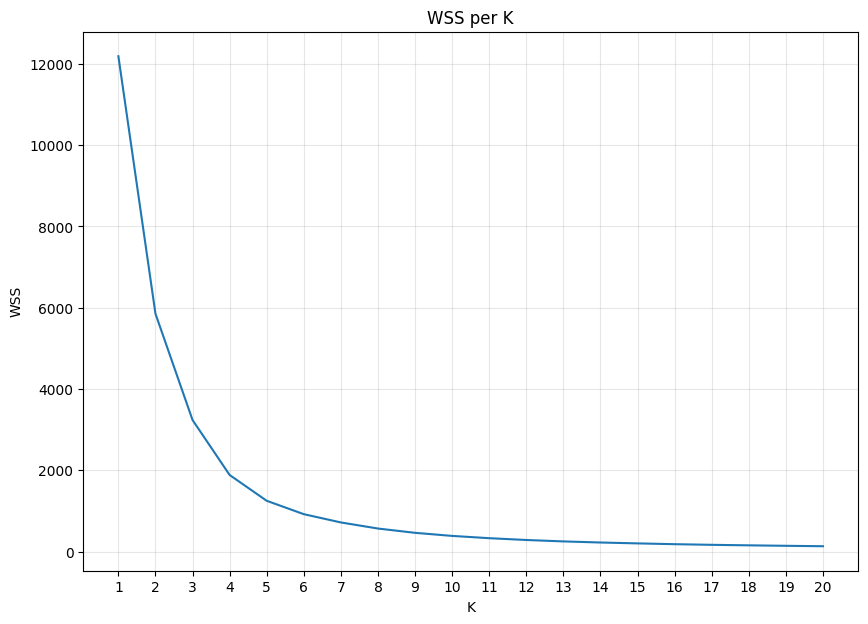

In [22]:
sub_graph_indices = list(sub_graph_index_to_sub_graph_nodes.keys())

sub_graph_index_vectors = torch.Tensor(sub_graph_indices).int()

sub_graph_embedded_vectors = (
    embedder_model(sub_graph_index_vectors)
    .detach().numpy()
)

plot_wss(
    points=sub_graph_embedded_vectors,
    kmax=20,
)

In [23]:
SELECTED_K = 7

kmeans = KMeans(n_clusters=SELECTED_K, n_init=20).fit(sub_graph_embedded_vectors)
predicted_clusters = kmeans.predict(sub_graph_embedded_vectors) + 1

#### Create Node to Cluster and Sub-Graph

In [24]:
node_to_cluster = {}
node_to_graph_index = {}

for sub_graph_index, cluster in zip(
    sub_graph_indices,
    predicted_clusters,
):
    for node in sub_graph_index_to_sub_graph_nodes[sub_graph_index]:
        node_to_cluster[node] = cluster
        node_to_graph_index[node] = sub_graph_index

#### Create Node Cluster Table

In [25]:
node_cluster_graph_df = spark.createDataFrame(
    [
        (
            node, 
            int(node_to_graph_index[node]), 
            int(node_to_cluster[node]),
        ) for node in node_to_cluster.keys()
    ],
    schema=["node", "subGraph","cluster"],
)

display_df(node_cluster_graph_df, display=DISPLAY)

root
 |-- node: string (nullable = true)
 |-- subGraph: long (nullable = true)
 |-- cluster: long (nullable = true)



23/10/22 23:21:44 WARN TaskSetManager: Stage 69 contains a task of very large size (1707 KiB). The maximum recommended task size is 1000 KiB.


DataFrame size: 210045
+----------------------------------------+--------+-------+
|node                                    |subGraph|cluster|
+----------------------------------------+--------+-------+
|0109c710fdb9da2a9cc0341004be8a16ea43a85a|1       |2      |
|000266fc1b59e4e289ec552a6282483d41a05859|1       |2      |
|0003ffa3b4b4519e4bfc0908ba1d62a64f4e0030|2       |7      |
|bc119da02146d4bd4d2dc49458c136ed2dc516a3|2       |7      |
|848fe2f62d0bb47e312c1b5a90bead09ce4774ec|2       |7      |
+----------------------------------------+--------+-------+
only showing top 5 rows



23/10/22 23:21:45 WARN TaskSetManager: Stage 72 contains a task of very large size (1707 KiB). The maximum recommended task size is 1000 KiB.


#### Add Cluster to graph-mining Data

In [26]:
graph_mining_with_cluster_df = (
    graph_mining_df
    .join(
        node_cluster_graph_df
        .select(
            F.col("node").alias("source"),
            "cluster",
            "subGraph",
        ),
        on="source",
        how="left",
    )
    .fillna(0, ["cluster", "subGraph"])
)

graph_mining_with_cluster_df.persist()

display_df(graph_mining_with_cluster_df, display=DISPLAY)

root
 |-- source: string (nullable = true)
 |-- destination: string (nullable = true)
 |-- count: string (nullable = true)
 |-- amount: string (nullable = true)
 |-- cluster: long (nullable = true)
 |-- subGraph: long (nullable = true)



23/10/22 23:21:46 WARN TaskSetManager: Stage 74 contains a task of very large size (1707 KiB). The maximum recommended task size is 1000 KiB.


DataFrame size: 1630291
+----------------------------------------+----------------------------------------+-----+------------------+-------+--------+
|source                                  |destination                             |count|amount            |cluster|subGraph|
+----------------------------------------+----------------------------------------+-----+------------------+-------+--------+
|00006b78202d11abbfa21ad7d099197cc1afcd9e|14e6c886bbeb14faf3d422e811ed41c5b444cad3|5    |3.0001883875471016|0      |0       |
|00006b78202d11abbfa21ad7d099197cc1afcd9e|4eefe70eec5ed0372971950ea92c6a57e35a0d52|1    |3.000008694763791 |0      |0       |
|00006b78202d11abbfa21ad7d099197cc1afcd9e|7920a754d84f6d3d0eeabd4d95bdd4d9d7c622aa|20   |3.0143705921653554|0      |0       |
|00007e715dd5ba36ea1678c2ef663cf276280267|7cd70978c5dfa8243ce313f1d583c844c6ecd340|4    |3.0017293014684987|0      |0       |
|00007e715dd5ba36ea1678c2ef663cf276280267|dfba3638c6d68c7200a5b5c5047b50826cc2945c|1    |3.000

#### Describe each Cluster

In [27]:
describe = (
    graph_mining_with_cluster_df
    .groupBy("subGraph")
    .agg(
        F.sum("count").alias("countTransactions"),
        F.sum("amount").alias("sumTransaction"),
        F.first("cluster").alias("cluster"),
    )
    .groupBy("cluster")
    .agg(
        F.count(F.lit(0)).alias("subGraphCount"),
        F.mean("countTransactions").alias("meanCountTransaction"),
        F.min("countTransactions").alias("minCountTransaction"),
        F.max("countTransactions").alias("maxCountTransaction"),
        F.mean("sumTransaction").alias("meanTransaction"),
        F.min("sumTransaction").alias("minTransaction"),
        F.max("sumTransaction").alias("maxTransaction"),
    )
    .orderBy("cluster")
    .collect()
)

for cluster in describe:
    print("Cluster:", cluster["cluster"])
    print("Number of Sub-Graphes:", cluster["subGraphCount"])
    print("Min Count Transaction:", cluster["minCountTransaction"])
    print("Mean Count Transaction:", cluster["meanCountTransaction"])
    print("Max Count Transaction:", cluster["maxCountTransaction"])
    print("Min Sum Transaction:", cluster["minTransaction"])
    print("Mean Sum Transaction:", cluster["meanTransaction"])
    print("Max Sum Transaction:", cluster["maxTransaction"])
    print("**********************************")

Cluster: 0
Number of Sub-Graphes: 1
Min Count Transaction: 6440769.0
Mean Count Transaction: 6440769.0
Max Count Transaction: 6440769.0
Min Sum Transaction: 4353867.242257056
Mean Sum Transaction: 4353867.242257056
Max Sum Transaction: 4353867.242257056
**********************************
Cluster: 1
Number of Sub-Graphes: 8918
Min Count Transaction: 1.0
Mean Count Transaction: 10.86588921282799
Max Count Transaction: 446.0
Min Sum Transaction: 3.000000048256207
Mean Sum Transaction: 8.176918759934715
Max Sum Transaction: 90.0076740397065
**********************************
Cluster: 2
Number of Sub-Graphes: 14249
Min Count Transaction: 1.0
Mean Count Transaction: 6.38079865253702
Max Count Transaction: 414.0
Min Sum Transaction: 3.0
Mean Sum Transaction: 5.650243002104151
Max Sum Transaction: 108.016964929186
**********************************
Cluster: 3
Number of Sub-Graphes: 2430
Min Count Transaction: 1.0
Mean Count Transaction: 33.958847736625515
Max Count Transaction: 555.0
Min Sum T